In [1]:
'''
increasing exposure time to account for photon noise

need to set up env variable before running notebook

terminal command: export PYSYN_CDBS = /Users/tchawla/research/HST_data/grp/redcat/trds
or: point towards correct directory. var name mys be PYSYN_CDBS

running other notebooks here so I can access their written functions
'''

import numpy as np
from astropy.io import ascii
from pylab import *
from astropy.table import Table, vstack
import pandas as pd
from expecto import get_spectrum
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import binned_statistic as bin
from itertools import product
%run Interpolate_final_v2.ipynb
%run GetSpectra_final_v2.ipynb
%run Binning_final_v2.ipynb
%run AddNoise_final_v2.ipynb
%run Model.ipynb
import batman

/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/angelachawla/Documents/research/pwv_noise_removal/Data/HST_data/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

'''
reads in .dat files. col1 is wavelength, col2 is transmission. Files are labeled with water content level in mm 
water content levels are listed in the array above. resolution is 200,000.
'''

d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("../Data/transmission{0}_hi_res.dat".format(water_content))
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1

In [3]:
'''
for loop creates transmission values in shape necessary for interpolation function
'''
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

flux_array = []
i=0
for n in water_array:
    water_array_i = str(water_array[i])
    d["flux"+water_array_i] = np.array(d["data"+water_array_i+"_pd"]["col2"])
    flux_array.append(d["flux"+water_array_i])
    i+=1

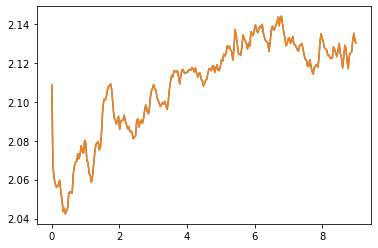

In [4]:
'''
setting angular separation values for pwv timeseries. Separation parameter at the ent of t1 line. 
Here, separation is 0, testing effect of second order exinction

Covers 9 hours (270 points, each point is two minutes)
'''


timestamps = np.linspace(0,9,270) 
t, target_star_pwv, target_star_phase, target_star_mean = power_spectrum(12000, 1, 24000, timestamps, mean = 2)
t1, comparison_star_pwv, _, _ = power_spectrum(12000, 1, 24000, timestamps, mean = target_star_mean, target = False, phase = target_star_phase, separation = 0)

plt.plot(t, target_star_pwv)
plt.plot(t, comparison_star_pwv)
plt.show()


In [5]:
'''
Reading in transit data for three planets. Starting with hot jupiter in this notebook
'''


water_world_abs1 = ascii.read("../Data/water_world_abs1.dat")
water_world_abs2 = ascii.read("../Data/water_world_abs2.dat")
water_world_abs3 = ascii.read("../Data/water_world_abs3.dat")
water_world_abs4 = ascii.read("../Data/water_world_abs4.dat")

hot_jupiter_abs1 = ascii.read("../Data/hot_jupiter_abs1.dat")
hot_jupiter_abs2 = ascii.read("../Data/hot_jupiter_abs2.dat")
hot_jupiter_abs3 = ascii.read("../Data/hot_jupiter_abs3.dat")
hot_jupiter_abs4 = ascii.read("../Data/hot_jupiter_abs4.dat")

warm_jupiter_abs1 = ascii.read("../Data/warm_jupiter_abs1.dat")
warm_jupiter_abs2 = ascii.read("../Data/warm_jupiter_abs2.dat")
warm_jupiter_abs3 = ascii.read("../Data/warm_jupiter_abs3.dat")
warm_jupiter_abs4 = ascii.read("../Data/warm_jupiter_abs4.dat")

In [6]:
'''
wave ranges will let us compare index to wavelength for each abs chunk

ex: hot_jupiter_abs1[20] will have wavelength wave_range_abs1[20]
'''

wave_range_abs1 = bin_array(.6, 1, 200)
wave_range_abs2 = bin_array(1, 1.25, 200)
wave_range_abs3 = bin_array(1.25, 1.56, 200)
wave_range_abs4 = bin_array(1.56, 2.1, 200)

In [7]:
'''
mag 4 stars in oct 26 file. here, running with mag 7
'''

target_spec = np.load("../Data/target_T4000_mag7.npy")
ref_spec_3000 = np.load("../Data/ref_T3000_mag7.npy")
ref_spec_5000 = np.load("../Data/ref_T5000_mag7.npy")
ref_spec_7000 = np.load("../Data/ref_T7000_mag7.npy")

In [ ]:
'''
function that takes in stellar spectrum, wave range, and res. Output is timeseries of flux based on pwv variability,
one timeseries for each wavelength. 
'''


def binned_flux_pwv_v2(spectrum, pwv_input, wave_in, wave_out, res):
    stellar = spec_wave_range(spectrum, wave_in, wave_out)
    stellar_wave = stellar[0]
    stellar_flux = stellar[1]
    #pwv = np.load("pwv_target.npy")
    
    
    transmission_array = []
    
    i=0
    for n in stellar_wave:
        str_value = str(stellar_wave[i])
        value = stellar_wave[i]/10
        stellar_flux_value = stellar_flux[i]
        transmission  = interpolate_water(pwv_input, value)
        flux = stellar_flux_value*transmission
        d[str_value+"_trans_array"] = np.array(flux)
    
        transmission_array.append(d[str_value+"_trans_array"])
        i+=1
        
    transmission_array = np.array(transmission_array)
    
    time_array = np.arange(0, len(pwv_input), 1)
    
    transmission_array_binned = []
    #wave_in_converted = wave_in*1000
    #wave_out_converted = wave_out*1000
    wave_in_converted = wave_in*100
    wave_out_converted = wave_out*100
    
    #print(stellar_wave)
    j=0
    #wave_array = res_bin_timestamp(transmission_array[:,j], stellar_wave, res, wave_in_converted, wave_out_converted)[1]
    for n in time_array:
        
        bin_1 = res_bin_timestamp(transmission_array[:,j], stellar_wave, res, wave_in_converted, wave_out_converted)
        transmission_array_binned.append(bin_1)
        j+=1
    
    return transmission_array_binned

In [41]:
'''
calculates photon noise, normalized to 0. throughput and transmission are fractional values. Transmission is set up to be
calculated over array of water content values (for pwv timeseries). 

Questions: how do we get initial photon count from the star from the flux? In practice I think we could get that value
directly from Henrietta's CCD detectors, but how do we do it simulation?

I guess if it's normalized, it's really calculting a percentage value and not actual changes in flux, and any flux values
could be used.

What units for exposure time? (pwv time series, each point is 1 minute) (needs to compare to flux, meausured in photons/sec)

re-write in terms of gaussian

after re-writing: I'm getting significantly different values from the gaussian and poisson distributions. It seems like 
poisson dist has much (orders of mag) larger std dev. Maybe I'm using the np version of the random generator wrong?
I thought poisson std dev was supposed to decrease with point count, but it still seems large even with values of 10**14

missing bin size, should be low resolution bin size

Note: right now, bin sizes are in angstroms, since this is the unit that the hi-res flux comes with. Bin sizes are filtered
from binning function to stacking to division_noise to photon_noise. bin sizes for 1.8-1.95 microns are about 180-190 A. 
'''

def photon_noise(flux, bin_size, mirror_diameter = 100, exp_time = 120, throughput = .4):
    
    mirror_area = np.pi*((mirror_diameter/2)**2) - np.pi*((25)**2)
    #print("mirror area:"+str(mirror_area))
    
    #bin_size_array = [bin_array[1]-bin_array[0]]
    '''
    i=0
    for n in bin_array:
        if i == len(bin_array)-1:
            break
        bin_size2 = bin_array[i+1] - bin_array[i]
        bin_size_array.append(bin_size2)
        j+=1
    '''
    num_photons = flux*mirror_area*exp_time*throughput*bin_size
    #print("num photons:"+str(num_photons[0:10]))
    noise_std_dev = 1/(num_photons**(1/2))
    #print("noise std dev: "+str(noise_std_dev))
    
    photon_noise_gaussian = np.random.normal(1, noise_std_dev, len(flux))
    
    return photon_noise_gaussian


'''
throughput of 0.4, swope is 1m in diameter, hole is .5m in diameter
'''

'\nthroughput of 0.4, swope is 1m in diameter, hole is .5m in diameter\n'

In [10]:
target_binned_abs3 = binned_flux_pwv_v2(target_spec, target_star_pwv, 1.25, 1.56, 200)

In [11]:
ref_binned_abs3 = binned_flux_pwv_v2(ref_spec_3000, comparison_star_pwv, 1.25, 1.56, 200)

In [12]:
target_stacked_abs3 = stacking(target_binned_abs3)
ref_stacked_abs3 = stacking(ref_binned_abs3)

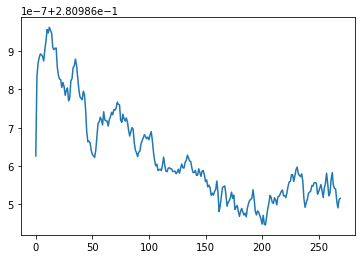

In [40]:
plt.plot(target_stacked_abs3[0][:,1])
#plt.plot(ref_stacked_abs3[0][30])

In [36]:
len(target_stacked_abs3[0][30])

44

In [18]:
'''
batman transit parameters. Using real rp and period
'''

params_hot_jupiter = batman.TransitParams()       #object to store transit parameters
params_hot_jupiter.t0 = 0.                        #time of inferior conjunction
params_hot_jupiter.per = 4.7361                       #orbital period 

# assume rp of .07 for now
params_hot_jupiter.rp = 0.04644                       #planet radi`us (in units of stellar radii)
#at each wavelength, add transit depth for atm. Will alter rp parameter
#change in atm depth in ppm
#Depth is rp^2 (because it's in units of solar radii)
#As such, rp is sqrt of depth



params_hot_jupiter.a = 4.98                        #semi-major axis (in units of stellar radii)
params_hot_jupiter.inc = 90                      #orbital inclination (in degrees)
params_hot_jupiter.ecc = 0.                       #eccentricity
params_hot_jupiter.w = 90.                        #longitude of periastron (in degrees)
params_hot_jupiter.limb_dark = "linear"        #limb darkening model
params_hot_jupiter.u = [0.5]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.5, 0.5, 270)  #times at which to calculate light curve
model_hot_jupiter = batman.TransitModel(params_hot_jupiter, t)    #initializes model

Text(0.5, 0, 'Phase')

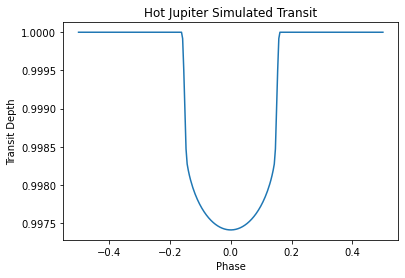

In [19]:
'''
plotted simulated transit, non-wavelength dependent
'''
transit = model_hot_jupiter.light_curve(params_hot_jupiter)
plt.plot(t, transit)

plt.title("Hot Jupiter Simulated Transit")
plt.ylabel("Transit Depth")
plt.xlabel("Phase")

#plt.savefig("transit.png")

In [42]:
def division_noise_transit_refinc(target_array, ref_array, atm, params):
    new_array1 = []
    target_array_1 = []
    ref_array_1 = []
    bin_size_array = [target_array[1][1]-target_array[1][0]]
    
    t = np.linspace(-0.5, 0.5, 270)
    #print("right function!")
    bulk_transit_depth = params.rp**2
    print("bulk_transit_depth: "+str(bulk_transit_depth))
    print("bulk_rp: "+str(params.rp))
    #new_array2
    i=0
    for n in target_array[0][0]:
        if i >= len(atm["col5"]):
            break
        
        bin_size = target_array[1][i+1]-target_array[1][i]
        #print("bin size: "+str(bin_size))
        bin_size_array.append(bin_size)
        target_array_i = np.array(target_array[0][:,i])
        #print(target_array_i[50:60])
        #print("original target array"+str(target_array_i[0:10]))
        
        #adding transit
        atm_transit_i = atm["col5"][i]/10**6
        #print("atm transit: "+ str(atm_transit_i))
        #print("atm depth"+str(atm_transit_i))
        
        total_transit_depth = bulk_transit_depth + atm_transit_i
        #print("total transit depth: "+ str(total_transit_depth))
        rp_i = np.sqrt(total_transit_depth)
        #print("rp i : "+ str(rp_i))
        params.rp = rp_i
        #print("edited param : "+ str(params.rp))
        #print("rp"+str(params.rp))
        model = batman.TransitModel(params, t)
        transit = model.light_curve(params)
        #print("transit model"+str(transit[500:510]))
        plt.plot(transit)
        
        #flux = stellar_flux_value*transmission
        #print("transit length " + str(len(transit)))
        #print("target array length " + str(len(target_array_i)))
        transit_flux = transit*target_array_i

        #plt.plot(transit_flux)
        #print("flux with transit"+str(transit_flux[0:10]))
        
        
        ref_array_i = np.array(ref_array[0][:,i])
        #print(ref_array_i[50:60])
        target_noise = photon_noise(transit_flux, bin_size)
        #print("target_noise: "+str(target_noise))
        ref_noise = photon_noise(ref_array_i, bin_size)
        #print("ref_noise: "+str(ref_noise))
        noisy_target_i = target_noise*transit_flux
        target_array_1.append(noisy_target_i)
        #plt.plot(noisy_target_i)
        #print("target_noisy flux: "+str(noisy_target_i))
        noisy_ref_i = ref_noise*ref_array_i
        ref_array_1.append(noisy_ref_i)
        #print("ref_noisy flux: "+str(noisy_ref_i))
        divided_i = noisy_target_i/noisy_ref_i
        #plt.plot(divided_i)
        #print("div_noisy flux: "+str(divided_i))
        new_array1.append(divided_i)
        i+=1
        #if i == 3:
            #break
    return new_array1, target_array_1, ref_array_1

#cold_star_abs1_test3[:,0]


bulk_transit_depth: 0.0021566736
bulk_rp: 0.04644


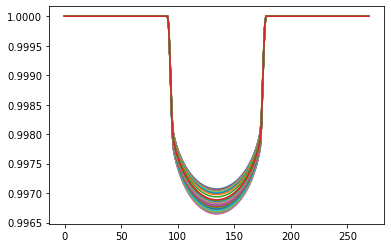

In [43]:
params_hot_jupiter.rp = 0.04644  
diff = division_noise_transit_refinc(target_stacked_abs3, ref_stacked_abs3, hot_jupiter_abs3, params_hot_jupiter)

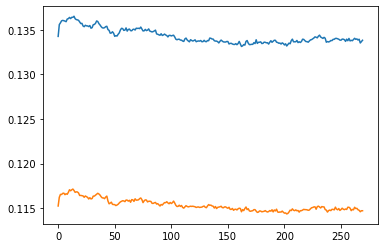

In [48]:
#plt.plot(diff[0][25])
plt.plot(diff[1][25])
plt.plot(diff[2][25])

In [ ]:
def normalize(diff):
    '''
    target_spec = spectrum(target_temp, mag1)
    ref_spec = spectrum(ref_temp, mag2)
    
    target_binned = binned_flux_pwv_v2(target_spec, target_pwv, wave_in, wave_out, res)
    ref_binned = binned_flux_pwv_v2(ref_spec, ref_pwv, wave_in, wave_out, res)
    target_stacked = stacking(target_binned)
    ref_stacked = stacking(ref_binned)
    diff = division_noise(target_stacked, ref_stacked)
    
    #print(diff[0])
    '''
    normalized_array = []
    #photon_noise_array = 
    
    i=0
    for n in diff:
        '''
        input to photon noise needs to be actual flux value, not relative value after division. Needs to be multiplied into
        both target and ref fluxes?
        '''
        #photon_noise_i = photon_noise(diff[i], .5, exp_time, throughput)
        #print(photon_noise_i)
        #noisy_diff = diff[i]*photon_noise_i
        diff_mean = (np.mean(diff[i][0:150])+np.mean(diff[i][390:540]))/2
        normalized = (diff[i]-diff_mean)/diff_mean
        normalized_array.append(normalized)
        #j=0
        #for n in normalized:
            #photon_noise(normalized[j], .5, exp_time, throughput
        #print(diff_mean)
        i+=1
    #diff_mean = np.mean(diff)
    #normalized = (diff-diff_mean)/diff_mean
    
    
    return normalized_array

In [45]:
len(diff[1][1])

270

In [51]:
def it_norm(array):
    normalized_array = []
    i=0
    for n in array:
        diff_mean = (np.mean(diff[i][0:75])+np.mean(diff[i][195:270]))/2
        normalized = (diff[i]-diff_mean)/diff_mean
        normalized_array.append(normalized)
        i+=1
    return normalized_array